# Your first autoencoder

Version 1.1

(C) 2020 - Umberto Michelucci, Michela Sperti

This notebook is part of the book _Applied Deep Learning: a case based approach, **2nd edition**_ from APRESS by [U. Michelucci](mailto:umberto.michelucci@toelt.ai) and [M. Sperti](mailto:michela.sperti@toelt.ai).

This notebook is referenced in Chapter 25 and 26 in the book.

## Notebook learning goals

At the end of this notebook you will be able to build a simple autoencoder with Keras, using `Dense` layers in Keras and apply to images, in particular to the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset and the [fashion MNIST](https://keras.io/api/datasets/fashion_mnist/) dataset as examples.

## Libraries Import

In [1]:
import numpy as np
import tensorflow.keras as keras
import pandas as pd
import time
import sys

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

import tensorflow as tf

## MNIST and FASHION MNIST dataset 

For this notebnook we will use two datasets:

- [MNIST Dataset](http://yann.lecun.com/exdb/mnist/)
- [Fashion MNIST @ Zalando](https://research.zalando.com/welcome/mission/research-projects/fashion-mnist/)

You can check the two datasets with the links above. They can be easily imported using keras. Below you can see how easy is using [```tensorflow.keras.datasets```](https://www.tensorflow.org/api_docs/python/tf/keras/datasets).

In [2]:
from keras.datasets import mnist
import numpy as np
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


As usual we will do the typical normalisation of the datasets as you can see below. At this point in the book you should be able to understand the code below easily.

In [3]:
mnist_x_train = mnist_x_train.astype('float32') / 255.
mnist_x_test = mnist_x_test.astype('float32') / 255.
mnist_x_train = mnist_x_train.reshape((len(mnist_x_train), np.prod(mnist_x_train.shape[1:])))
mnist_x_test = mnist_x_test.reshape((len(mnist_x_test), np.prod(mnist_x_test.shape[1:])))

In [4]:
from keras.datasets import fashion_mnist
import numpy as np
(fashion_x_train, fashion_y_train), (fashion_x_test, fashion_y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


Note that we are doing the same normalisation for the fashion mnist datasets as for the classical MNIST.

In [5]:
fashion_x_train = fashion_x_train.astype('float32') / 255.
fashion_x_test = fashion_x_test.astype('float32') / 255.
fashion_x_train = fashion_x_train.reshape((len(fashion_x_train), np.prod(fashion_x_train.shape[1:])))
fashion_x_test = fashion_x_test.reshape((len(fashion_x_test), np.prod(fashion_x_test.shape[1:])))

## Function to create the autoencoders

Now we need to create the ```keras``` models. An autoencoder is made of two main parts: an _encoder_ and a _decoder_. The function below ```create_autoencoders()``` returns the following parts as separate models:

- The encoder 
- the decoder
- the complete model, when the encoder and decoder are joined in one model.

In [6]:
def create_autoencoders (feature_layer_dim = 16):
  input_img = Input(shape = (784,), name = 'Input_Layer')
  # The layer encoded has a dimension equal to feature_layer_dim and contains
  # the encoded input (therefore the name)
  encoded = Dense(feature_layer_dim, activation = 'relu', name = 'Encoded_Features')(input_img)
  decoded = Dense(784, activation = 'sigmoid', name = 'Decoded_Input')(encoded)

  autoencoder = Model(input_img, decoded)
  encoder = Model(input_img, encoded)

  encoded_input = Input(shape = (feature_layer_dim,))
  decoder = autoencoder.layers[-1]
  decoder = Model(encoded_input, decoder(encoded_input))

  return autoencoder, encoder, decoder

## Autoencoder with layers with $(784,616,784)$ neurons.

As a first step let's create an autoencoder with the layer dimensions of $(784, 16, 784)$.




In [ ]:
autoencoder, encoder, decoder = create_autoencoders (16)

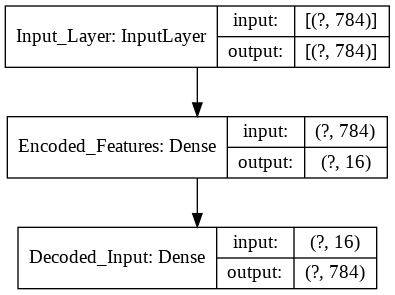

In [ ]:
keras.utils.plot_model(autoencoder, show_shapes=True)

As for any keras model we need to compile the model and the fit it to the data. As you can see we don't need any custom code to work with autoencoders. A simple model **definition** $\rightarrow$ **compile** $\rightarrow$ **fit** is enough.

In [ ]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
history = autoencoder.fit(mnist_x_train, mnist_x_train,
                epochs=30,
                batch_size=256,
                shuffle=True,
                validation_data=(mnist_x_test, mnist_x_test),
                verbose = 0)

In [ ]:
encoded_imgs = encoder.predict(mnist_x_test)
decoded_imgs = decoder.predict(encoded_imgs)

### Some notes about compression

Since we have saved both the encoder and the decoder we can generate an encoded version of the images. Note that the data type of the images is ```float32```. Each ```float32``` require 4 bytes. The original data ```mnist_x_test``` has a shape of ```(10000,784)```. That means that the space needed to save this array is 

$$
10000 \textrm{ images} \times 784 \textrm{ pixels}\times 4 \textrm{ bytes} = 29 \textrm{ Mb}
$$

The encoded images require quite less space. Infact the size needed is

$$
10000 \textrm{ images}\times 16 \textrm{ latent features}\times 4 \textrm{ bytes} = 625 \textrm{ Kb}
$$

so if we accept the loss in quality in the compressed data we have achieved an incredible compression ratio of ca. $46$. It is easy to check those sizes by saving the data in a file and checking the file size. Note that the file size will be bigger, since there is some additional information that needs to be saved.

In [ ]:
np.save('temp_orig', mnist_x_test)
! ls -al temp_orig*

-rw-r--r-- 1 root root 31360128 Oct 28 15:30 temp_orig.npy


In [ ]:
np.save('temp_encoded', encoded_imgs)
! ls -al temp_encoded*

-rw-r--r-- 1 root root 640128 Oct 28 15:30 temp_encoded.npy


## Reconstructed images analysis

As noted above we have basically compressed our input images. But at what price? In the images below you can see what is the effect of having only 16 neurons in the middle layer.



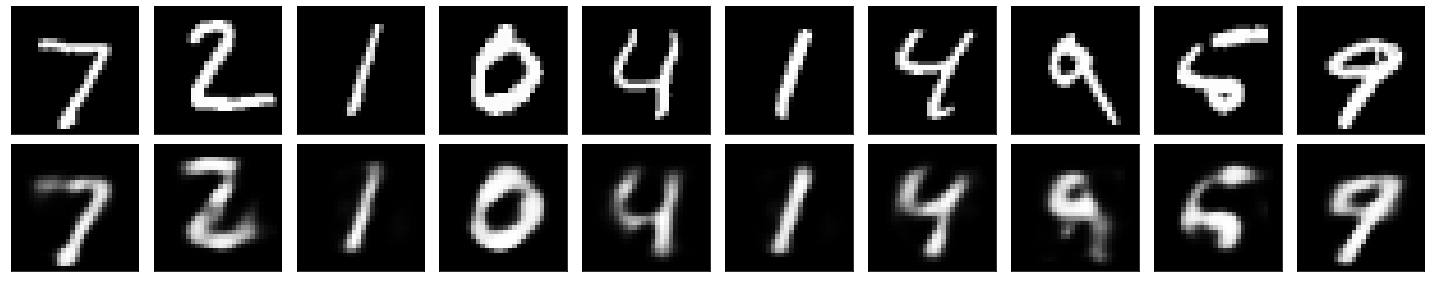

In [ ]:
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
fig = plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(mnist_x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

fig.savefig('comparison_16.png')

## Autoencoder with layers with $(784,64,784)$ neurons.







In [ ]:
autoencoder, encoder, decoder = create_autoencoders (64)

In [ ]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
autoencoder.fit(mnist_x_train, mnist_x_train,
                epochs=30,
                batch_size=256,
                shuffle=True,
                validation_data=(mnist_x_test, mnist_x_test),
                verbose = 0)

In [ ]:
encoded_imgs = encoder.predict(mnist_x_test)
decoded_imgs = decoder.predict(encoded_imgs)

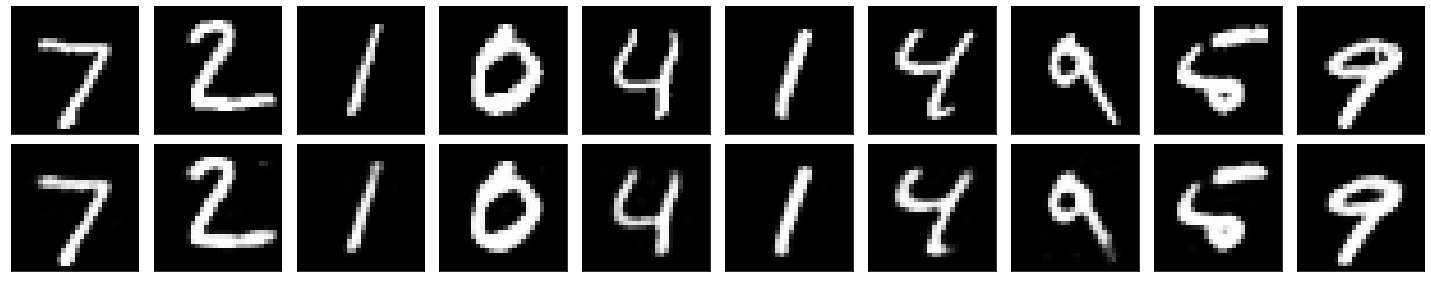

In [ ]:
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
fig = plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(mnist_x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

fig.savefig('comparison_32.png')

## Autoencoder with layers with $(784,8,784)$ neurons.

We can check how, reducing the number of neurons in the middle layer, the quality of the reconstruction drops since the dimensionality reduction is too extreme in this case.

In [ ]:
autoencoder, encoder, decoder = create_autoencoders (8)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(mnist_x_train, mnist_x_train,
                epochs=30,
                batch_size=256,
                shuffle=True,
                validation_data=(mnist_x_test, mnist_x_test),
                verbose = 0)

In [ ]:
encoded_imgs = encoder.predict(mnist_x_test)
decoded_imgs = decoder.predict(encoded_imgs)

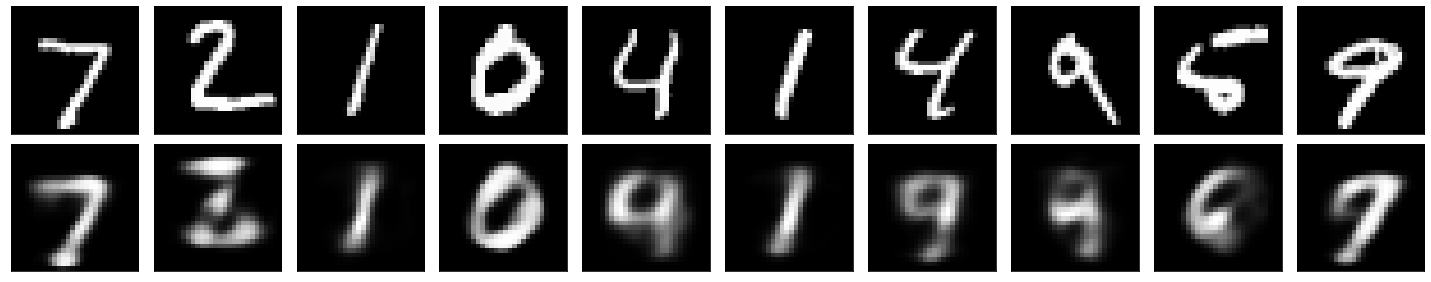

In [ ]:
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
fig = plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(mnist_x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

fig.savefig('comparison_8.png')

## Classification with the latent features
Now let's check how we can use the latent features, or in other words the output of the middle layer, to do some classification. Are loosing much accuracy? What about performance of the algorithms? Let's check some examples.

### kNN Study

The first algorithm that we can test is kNN. To do it we can simply use ```sklearn```.

In [ ]:
encoded_train_imgs = encoder.predict(mnist_x_train)
#decoded_imgs = decoder.predict(encoded_imgs)

note how the variable ```encoded_train_imgs``` has only 8 features (remember the last autoencoders we trained had only 8 neurons in the middle layer). The original dataset had 784 features (the pixel gray values of the images).

In [ ]:
encoded_train_imgs.shape

(60000, 8)

In [ ]:
def plot_confusion_matrix(data, labels, output_filename):
    """Plot confusion matrix using heatmap.
 
    Args:
        data (list of list): List of lists with confusion matrix data.
        labels (list): Labels which will be plotted across x and y axis.
        output_filename (str): Path to output file.
 
    """
    sns.set(color_codes=True)
    plt.figure(1, figsize=(9, 6))
 
    sns.set(font_scale=1.3)
    ax = sns.heatmap(data, annot=True, cmap="Blues", cbar_kws={'label': 'Scale'},fmt='d')
 
    ax.set_xticklabels(labels, fontsize = 16)
    ax.set_yticklabels(labels, fontsize = 16)
 
    ax.set_xlabel("Predicted Label", fontsize = 16)
    ax.set_xlabel("True Label", fontsize = 16)
 
    plt.savefig(output_filename, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

In [ ]:
# importing necessary libraries 
from sklearn import datasets 
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
import seaborn as sns

We will now train the classifier with the encoded images and we will measure how long it takes for the training. Later we will do the same with the original dataset and compare results and running time.

In [ ]:
start = time.time()
 
# training a KNN classifier 
from sklearn.neighbors import KNeighborsClassifier 
knn = KNeighborsClassifier(n_neighbors = 7).fit(encoded_train_imgs, mnist_y_train) 
  
# accuracy on X_test 
accuracy = knn.score(encoded_imgs, mnist_y_test) 
print (accuracy )

end = time.time()
print("Running time",end - start,"sec.") 


0.8921
Running time 1.1384508609771729 sec.


With just the 8 features we get an incredible 89% of accuracy in 1.1 sec. 

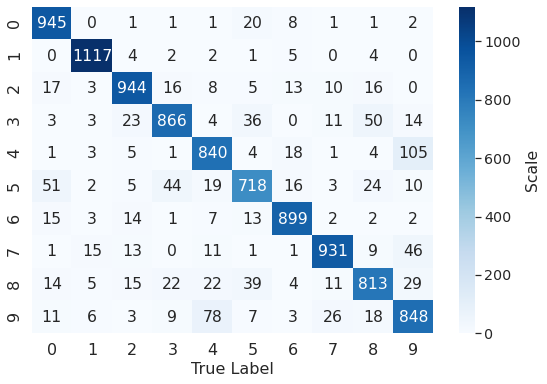

In [ ]:
# creating a confusion matrix 
knn_predictions = knn.predict(encoded_imgs)  
cm = confusion_matrix(mnist_y_test, knn_predictions)
cm 
plot_confusion_matrix(cm, [0,1,2,3,4,5,6,7,8,9], "confusion_matrix.png")

### kNN With all the features

Now let's train a classifier with all 784 features.

In [ ]:
start = time.time()

from sklearn.neighbors import KNeighborsClassifier 
knn2 = KNeighborsClassifier(n_neighbors = 7).fit(mnist_x_train, mnist_y_train) 
# accuracy on X_test 
accuracy = knn2.score(mnist_x_test, mnist_y_test)  
print (accuracy )

end = time.time()
print("Running time",end - start,"sec.") 

0.9694
Running time 994.1694293022156 sec.


With all the features we get 96% accuracy (7% more than with just 8 features) but it takes 1000 times longer, around 16 minutes. If instead of 10000 observations we had few millions, this 1000 time gain will become not only significant but it may mean the difference between training a model or not being able to.

## MSE

Autoencoders are so flexible that they work even if we use as loss function the MSE. We can try it quickly in the example below. More details about the loss functions are discussed in the book.

In [7]:
dim = 16

input_img = Input(shape = (784,))
encoded = Dense(dim, activation = 'relu')(input_img)
decoded = Dense(784, activation = 'sigmoid')(encoded)

autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)

In [8]:
encoded_input = Input(shape = (dim,))
decoder = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder(encoded_input))

In [9]:
autoencoder.compile(optimizer='adam', loss='mse')

In [10]:
autoencoder.fit(mnist_x_train, mnist_x_train,
                epochs=30,
                batch_size=256,
                shuffle=True,
                validation_data=(mnist_x_test, mnist_x_test),
                verbose = 0)

In [11]:
encoded_imgs = encoder.predict(mnist_x_test)
decoded_imgs = decoder.predict(encoded_imgs)

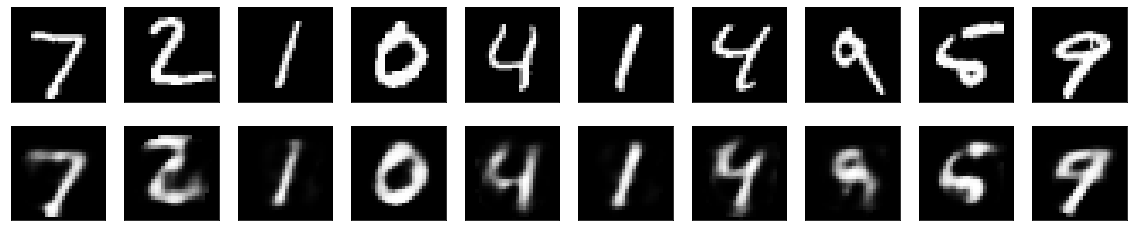

In [14]:
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
fig = plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(mnist_x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


fig.savefig('comparison_MSE_16.png')

## Fashion MNIST

We can use an autoencoder with the FASHION MNIST dataset now. We will just try to build one with 8 neurons in the middle layer.

In [ ]:
autoencoder, encoder, decoder = create_autoencoders (8)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(fashion_x_train, fashion_x_train,
                epochs=30,
                batch_size=256,
                shuffle=True,
                validation_data=(fashion_x_test, fashion_x_test),
                verbose = 1)

Epoch 1/30
235/235 [==============================] - 2s 8ms/step - loss: 0.4686 - val_loss: 0.3904
Epoch 2/30
235/235 [==============================] - 2s 8ms/step - loss: 0.3686 - val_loss: 0.3561
Epoch 3/30
235/235 [==============================] - 2s 8ms/step - loss: 0.3430 - val_loss: 0.3385
Epoch 4/30
235/235 [==============================] - 2s 8ms/step - loss: 0.3331 - val_loss: 0.3323
Epoch 5/30
235/235 [==============================] - 2s 8ms/step - loss: 0.3280 - val_loss: 0.3282
Epoch 6/30
235/235 [==============================] - 2s 8ms/step - loss: 0.3245 - val_loss: 0.3250
Epoch 7/30
235/235 [==============================] - 2s 8ms/step - loss: 0.3217 - val_loss: 0.3226
Epoch 8/30
235/235 [==============================] - 2s 8ms/step - loss: 0.3197 - val_loss: 0.3208
Epoch 9/30
235/235 [==============================] - 2s 8ms/step - loss: 0.3182 - val_loss: 0.3195
Epoch 10/30
235/235 [==============================] - 2s 8ms/step - loss: 0.3171 - val_loss: 0.3186

In [ ]:
encoded_imgs = encoder.predict(fashion_x_test)
decoded_imgs = decoder.predict(encoded_imgs)

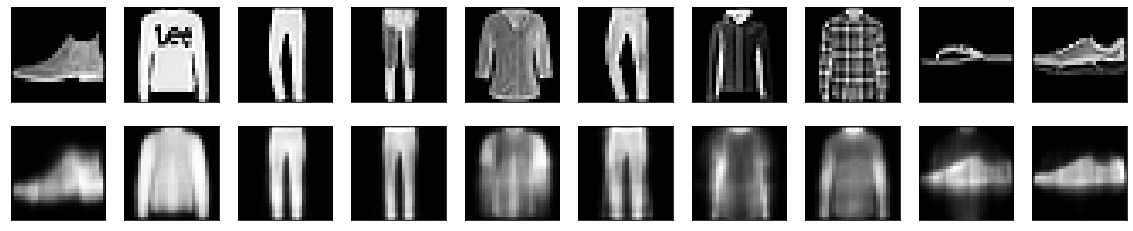

In [ ]:
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(fashion_x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

And again we can try to build a classifier with all the data. Also in this case, as it would be expected, it take almost 16 minutes. Quite a long time.

In [ ]:
start = time.time()

from sklearn.neighbors import KNeighborsClassifier 
knn = KNeighborsClassifier(n_neighbors = 7).fit(fashion_x_train, fashion_y_train) 
# accuracy on X_test 
accuracy = knn.score(fashion_x_test, fashion_y_test) 
print (accuracy )

end = time.time()
print(end - start)

0.854
1046.022537946701


## kNN on learned representation

In [ ]:
encoded_fashion_train_imgs = encoder.predict(fashion_x_train)
encoded_fashion_test_imgs = encoder.predict(fashion_x_test)

In [ ]:
start = time.time()
 
# training a KNN classifier 
from sklearn.neighbors import KNeighborsClassifier 
knn = KNeighborsClassifier(n_neighbors = 7).fit(encoded_fashion_train_imgs, fashion_y_train) 
  
# accuracy on X_test 
accuracy = knn.score(encoded_fashion_test_imgs, fashion_y_test) 
print (accuracy )

end = time.time()
print(end - start)

0.7993
1.2334933280944824


So again we loos ca. 5% of accuarcy but we are 1000 times faster. Quite impressive. 

## kNN Accuracy with an Autoencoder with number of neurons in the layers $(784,16,784)$

In [ ]:
autoencoder, encoder, decoder = create_autoencoders (16)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(fashion_x_train, fashion_x_train,
                epochs=30,
                batch_size=256,
                shuffle=True,
                validation_data=(fashion_x_test, fashion_x_test),
                verbose = 0)

In [ ]:
encoded_fashion_train_imgs = encoder.predict(fashion_x_train)
encoded_fashion_test_imgs = encoder.predict(fashion_x_test)

In [ ]:
start = time.time()
 
# training a KNN classifier 
from sklearn.neighbors import KNeighborsClassifier 
knn = KNeighborsClassifier(n_neighbors = 7).fit(encoded_fashion_train_imgs, fashion_y_train) 
  
# accuracy on X_test 
accuracy = knn.score(encoded_fashion_test_imgs, fashion_y_test) 
print (accuracy )

end = time.time()
print(end - start)

0.8363
3.0091614723205566


Now increasing the number of neurons in the middle layer to 16 will give us an accuracy equal to 93% in 3 seconds. A minor increase in running time that is well worth! Still doing the same classification with all the features would require 1000 sec.